In [ ]:
.Rhistory

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
churn = pd.read_csv('data/churn.csv')
for col in ['last_trip_date', 'signup_date']:
    churn[col] = pd.to_datetime(churn[col])
pull_date = pd.to_datetime('2014-07-01')
churn['active'] = ((pull_date - churn['last_trip_date']).dt.days <= 30)
churn['acct_age'] = ((pull_date - churn['signup_date']).dt.days)
for col in ['luxury_car_user', 'active']:
    churn[col] = churn[col].astype(int)

churn.dropna(inplace=True)

In [29]:
# scatter_matrix(churn.drop(['city', 'phone'], axis=1), figsize=(16,16), alpha=0.1)
# plt.suptitle('User Churn Scatter Matrix\n', size=16)
# plt.tight_layout()
# plt.show()

In [30]:
X = churn.copy().drop(['city', 'phone', 'last_trip_date', 'signup_date'], axis=1)
X.dropna(inplace=True)
y = X.pop('active')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

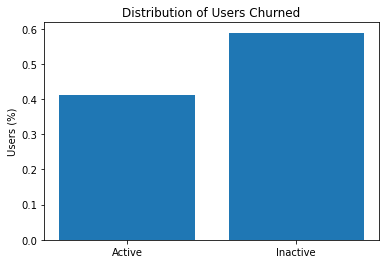

In [31]:
fig, ax = plt.subplots()
#ax.bar(df['active'])
x = ['Active', 'Inactive']
y = [churn['active'].sum() / churn['active'].count(), ((churn['active'].count() - churn['active'].sum()) / churn['active'].count())]
ax.bar(x, y)
ax.set_ylabel('Users (%)')
ax.set_title('Distribution of Users Churned');

In [32]:
dtc = DecisionTreeClassifier(random_state=1)
gdbc = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    random_state=1
)
rfc = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=1
)
models = {'Random Forest': rfc, 'Gradient Boosting': gdbc, 'Decision Tree': dtc}

def test_models(models, X_train, X_test, y_train, y_test):
    output = {}
    for i, (name, model) in enumerate(models.items()):
        output[name] = {}
        tests = {
            'Confusion Matrix': confusion_matrix,
            'Accuracy': accuracy_score,
            'Precision': precision_score,
            'Recall': recall_score
        }
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        for test_name, func in tests.items():
            output[name][test_name] = tests[test_name](y_test, pred)

    return output
    
def print_results(results):
    for model_name, res in results.items():
        print(f'{model_name} Classifier')
        for test_name, result in res.items():
            newline = '\n' if test_name == 'Confusion Matrix' else ''
            print(f'  {test_name}: {newline}{result}')
        print('')

In [33]:
results = test_models(models, X_train, X_test, y_train, y_test)

In [34]:
print_results(results)

Random Forest Classifier
  Confusion Matrix: 
[[4810 1310]
 [1600 2642]]
  Accuracy: 0.719166184134337
  Precision: 0.6685222672064778
  Recall: 0.6228194247996228

Gradient Boosting Classifier
  Confusion Matrix: 
[[5094 1026]
 [1636 2606]]
  Accuracy: 0.7430997876857749
  Precision: 0.7175110132158591
  Recall: 0.6143328618576144

Decision Tree Classifier
  Confusion Matrix: 
[[4345 1775]
 [1817 2425]]
  Accuracy: 0.6533487743678826
  Precision: 0.5773809523809523
  Recall: 0.5716643092880717



In [35]:
# gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
#                           'max_depth': [2, 4, 6],
#                           'min_samples_leaf': [1, 2, 5, 10],
#                           'max_features': [1.0, 0.3, 0.1],
#                           'n_estimators': [20, 50, 100, 200],
#                           'random_state': [1]}

# model_gridsearch = GridSearchCV(
#     gdbc,
#     gradient_boosting_grid,
#     n_jobs=-1,
#     verbose=True,
#     scoring='neg_mean_squared_error'
# )
# model_gridsearch.fit(X_train, y_train)
# model_gridsearch.best_params_
# model_gridsearch.best_estimator_

In [36]:
models = {
    'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features=0.3,
                           min_samples_leaf=5, n_estimators=200,
                           random_state=1)
}
results = test_models(models, X_train, X_test, y_train, y_test)
print_results(results)

Gradient Boosting Classifier
  Confusion Matrix: 
[[5116 1004]
 [1603 2639]]
  Accuracy: 0.7484076433121019
  Precision: 0.7244029645896239
  Recall: 0.6221122112211221



In [49]:
gbc0 = GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features=0.3,
                           min_samples_leaf=5, n_estimators=200,
                           random_state=1)
gbc0.fit(X_train, y_train)
prob_test_churn = gbc0.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_test_churn[:, 1])

# method 1: geometric means
geometric_means = (tpr * (1-fpr)) ** .5
best_thresh = thresholds[np.argmax(geometric_means)] 
best_thresh
decisions = (prob_test_churn[:,1] >= best_thresh).astype(int)
print(f'{confusion_matrix(y_test, decisions)} \naccuracy: {accuracy_score(y_test, decisions)} \nprecision: {precision_score(y_test, decisions)} \nrecall: {recall_score(y_test, decisions)}')
print('Precision takes a hit and recall (TP / TP+FN) increases substantially. In our case, we might want recall to increase so we catch more users who will churn')

# method 2: J-statistics
j_stats = tpr - fpr
best_thresh = thresholds[np.argmax(j_stats)]
decisions = (prob_test_churn[:,1] >= best_thresh).astype(int)
print(f'\n {confusion_matrix(y_test, decisions)} \naccuracy: {accuracy_score(y_test, decisions)} \nprecision: {precision_score(y_test, decisions)} \nrecall: {recall_score(y_test, decisions)}')

[[4746 1374]
 [1262 2980]] 
accuracy: 0.7456089558000386 
precision: 0.6844281120808452 
recall: 0.7024988213107025
Precision takes a hit and recall (TP / TP+FN) increases substantially. In our case, we might want recall to increase so we catch more users who will churn

 [[4868 1252]
 [1337 2905]] 
accuracy: 0.7501447596988998 
precision: 0.6988212653355785 
recall: 0.6848184818481848


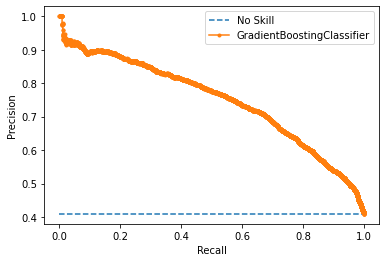

In [55]:
# Optimal threshold for precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, prob_test_churn[:,1])
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label=gbc0.__class__.__name__)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [56]:
# method: f-score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
best_thresh = thresholds[ix]
decisions = (prob_test_churn[:,1] >= best_thresh).astype(int)
print(f'\n {confusion_matrix(y_test, decisions)} \naccuracy: {accuracy_score(y_test, decisions)} \nprecision: {precision_score(y_test, decisions)} \nrecall: {recall_score(y_test, decisions)}')

Best Threshold=0.348547, F-Score=0.699

 [[4211 1909]
 [ 936 3306]] 
accuracy: 0.7254391044199962 
precision: 0.6339405560882071 
recall: 0.7793493635077794


In [ ]:
decisions = (prob_test_churn[:,1] >= best_thresh).astype(int)
print(f'{confusion_matrix(y_test, decisions)} \naccuracy: {accuracy_score(y_test, decisions)} \nprecision: {precision_score(y_test, decisions)} \nrecall: {recall_score(y_test, decisions)}')
print('Precision takes a hit and recall (TP / TP+FN) increases substantially. In our case, we might want recall to increase so we catch more users who will churn')

In [ ]:
gdbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=6, max_features=0.3,
                           min_samples_leaf=5, n_estimators=200,
                           random_state=1)
gdbc.fit(X_train, y_train)
predicted_target = gdbc.predict(X_test)
feat_scores = pd.Series(gdbc.feature_importances_,
                           index=X.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain')

Thresholding to help the model. Speaking of thresholding? There should be a ROC curve to speak to.

why did you leave out city and phone number?!

Base case is always what happens if I predict 1 class

simple descirption of data at the beginning
more practical at the end 
show confusion matrix with APR + use actual labels in CM chart

leave out number of estimators  and learning rate because we know what relationship exisrts between them already. Fix the learning rate and number of estimators, do grid search for other params and then adjust them later on.

When you get to a working model, your first thought is feature engineering and then grid search. feature engineer!!! it will be more beneficial then grid searching. grid search once you've maximized feature enginereing

dummyize other features

Things to do:
1. Plot fancy looking confusion matrix, highlight differences in presentation (as in, let's use this other threshold so we can optimize recall!)

In [26]:
def confusion_matrix(model, X, threshold=0.5):
    cf = pd.crosstab(ytest, predict(model, Xtest, threshold))
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=['Fraud', 'Not'], index=['Fraud', 'Not']), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

def plot_and_create_confusion_matrix(model, X, threshold=0.5, cb=None):
    cf = confusion_matrix(model, X, threshold=threshold)
    cm = cf.values 
    plot_confusion_matrix(cm, cf.index.values, cf.T.index.values )

In [16]:
# to plot different model performances
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from src.decision_rules import plot_profit_curve_v2


# Support Vector Machine separating hyperplanes are influenced by 
# feature sizes.
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
models = [GBC(), RF(n_jobs=-1), SVC(probability=True), 
          LogisticRegression(penalty='none')]
random_state = 1310
for i, model in enumerate(models):
    model.set_params(**{'random_state': random_state})
    model.fit(X_train_std, y_train)

fig, ax = plt.subplots(figsize=(16, 9))
profit_mat = [[3, -1], [0, 0]]
for model in models:
    plot_profit_curve_v2(model, profit_mat, X_test_std, y_test, ax=ax)
# Add profit matrix.
tp_profit, fp_profit, fn_profit, tn_profit = profit_mat.ravel()
table = [['Profit', 'Actual +', 'Actual -'], 
         ['Predicted +', tp_profit, fp_profit],
         ['Predicted -', fn_profit, tn_profit]]
ax.table(cellText=table, cellLoc='center', colWidths=[0.1] * 3, 
         loc='lower left')
plt.show()

KeyboardInterrupt: 